# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

/Users/manue/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/iMAT/master/etica_explicabilidad/jaime/practicas/p1-tabular-methods-rdgzmanuel/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()


short_name nationality  overall  potential  wage_eur  value_eur  \
0           L. Messi   Argentina       94         94    565000   95500000   
1  Cristiano Ronaldo    Portugal       93         93    405000   58500000   
2          Neymar Jr      Brazil       92         92    290000  105500000   
3           J. Oblak    Slovenia       91         93    125000   77500000   
4          E. Hazard     Belgium       91         91    470000   90000000   

   age  height_cm  weight_kg  attacking_crossing  ...  mentality_penalties  \
0   32        170         72                  88  ...                   75   
1   34        187         83                  84  ...                   85   
2   27        175         68                  87  ...                   90   
3   26        188         87                  13  ...                   11   
4   28        175         74                  81  ...                   88   

   mentality_composure  defending_marking  defending_standing_tackle  \
0                   96                 33                         37   
1                   95                 28                         32   
2                   94                 27                         26   
3                   68                 27                         12   
4                   91                 34                         27   

   defending_sliding_tackle  goalkeeping_diving  goalkeeping_handling  \
0                        26                   6                    11   
1                        24                   7                    11   
2                        29                   9                     9   
3                        18                  87                    92   
4                        22                  11                    12   

   goalkeeping_kicking  goalkeeping_positioning  goalkeeping_reflexes  
0                   15                       14                     8  
1                   15                       14                    11  
2                   15                       15                    11  
3                   78                       90                    89  
4                    6                        8                     8  

[5 rows x 43 columns]

In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

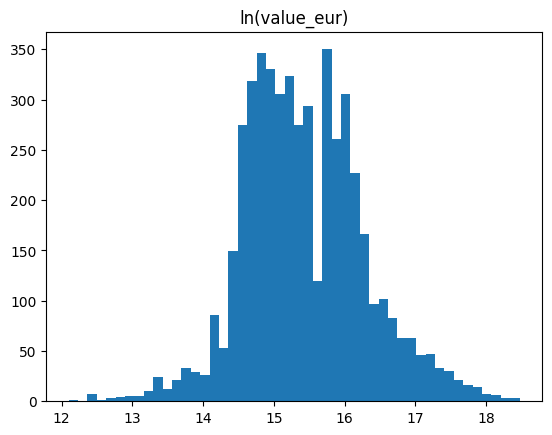

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, ylog, y, X.index,  # Add the index as another array to split
    test_size=0.3, 
    random_state=42
)

In [6]:
# Function to find position in split data
def find_player_position(original_idx, train_idx, test_idx):
    """Returns (dataset, position) where dataset is 'train' or 'test'"""
    if original_idx in train_idx:
        position = list(train_idx).index(original_idx)
        return 'train', position
    elif original_idx in test_idx:
        position = list(test_idx).index(original_idx)
        return 'test', position
    else:
        return None, None

messi_dataset, messi_position = find_player_position(0, train_idx, test_idx)
print(f"Messi is in {messi_dataset} set at position {messi_position}")

cr7_dataset, cr7_position = find_player_position(1, train_idx, test_idx)
print(f"CR7 is in {cr7_dataset} set at position {cr7_position}")

bk_dataset, bk_position = find_player_position(4, train_idx, test_idx)
print(f"BurgerKing is in {bk_dataset} set at position {bk_position}")

Messi is in train set at position 381
CR7 is in train set at position 1760
BurgerKing is in train set at position 3156


In [7]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor(max_depth=4, max_iterations=15)
model.fit(X_train, ylog_train)

[13:58:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_iterations" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_iterations=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [8]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [9]:
from sklearn.metrics import r2_score

train_pred = predict_function(model, X_train)
test_pred = predict_function(model, X_test)

train_mse = np.square(train_pred - y_train).mean()
test_mse = np.square(test_pred - y_test).mean()


train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Train MSE: {train_mse:.3f}")
print(f"Test MSE: {test_mse:.3f}")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

Train MSE: 890697391617.597
Test MSE: 8070727965880.822
Train R²: 0.989
Test R²: 0.891


In [10]:
for d in [2, 4, 6, 8]:
    model = XGBRegressor(max_depth=d, n_estimators=40, random_state=42)
    model.fit(X_train, ylog_train)
    print(f"Depth={d}, Train R2={r2_score(y_train, np.exp(model.predict(X_train))):.3f}, Test R2={r2_score(y_test, np.exp(model.predict(X_test))):.3f}")

Depth=2, Train R2=0.870, Test R2=0.836
Depth=4, Train R2=0.961, Test R2=0.885
Depth=6, Train R2=0.990, Test R2=0.897
Depth=8, Train R2=0.999, Test R2=0.882


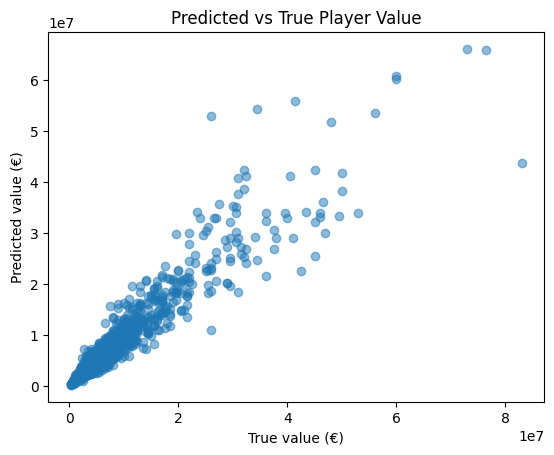

In [11]:
plt.scatter(y_test, test_pred, alpha=0.5)
plt.xlabel("True value (€)")
plt.ylabel("Predicted value (€)")
plt.title("Predicted vs True Player Value")
plt.show()

In general, the model is not overfitting too much. Ther's a notable difference between train and test, but test performance is very solid (almost 90%). Looking at the final plot, it seems to be a linear relationship, which is desired, despite some outliers with very high value that are not that well predicted.

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [12]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

In [13]:
baseline_pred = predict_function(model, X_test)
baseline_error = np.square(baseline_pred - y_test).mean()

scores = {}

for group_name, columns in variable_groups.items():
    X_perm = X_test.copy()
    
    for col in columns:
        X_perm[col] = np.random.permutation(X_perm[col].values)
    
    perm_pred = predict_function(model, X_perm)
    perm_error = np.square(perm_pred - y_test).mean()
    
    importance = perm_error - baseline_error
    scores[group_name] = importance

importance_df = pd.DataFrame(scores.items(), columns=["Group", "Importance"]).sort_values(by="Importance", ascending=False)

importance_df


Group    Importance
4     movement  2.287812e+13
2    attacking  1.753518e+13
3        skill  1.533804e+13
0          age  1.352071e+13
6    mentality  7.659295e+12
5        power  5.706527e+12
8  goalkeeping  5.619499e+12
7    defending  5.032425e+12
1         body  3.468632e+11

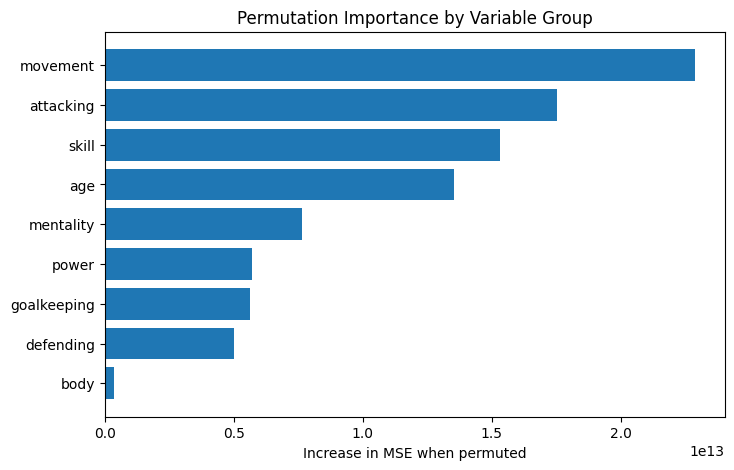

In [14]:
plt.figure(figsize=(8,5))
plt.barh(importance_df["Group"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Permutation Importance by Variable Group")
plt.xlabel("Increase in MSE when permuted")
plt.show()

By plotting the increase in MSE after permuting the values of each group, we can see which features had the biggest negative impact when randomized, meaning that they were bery important for the model's prediction.

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

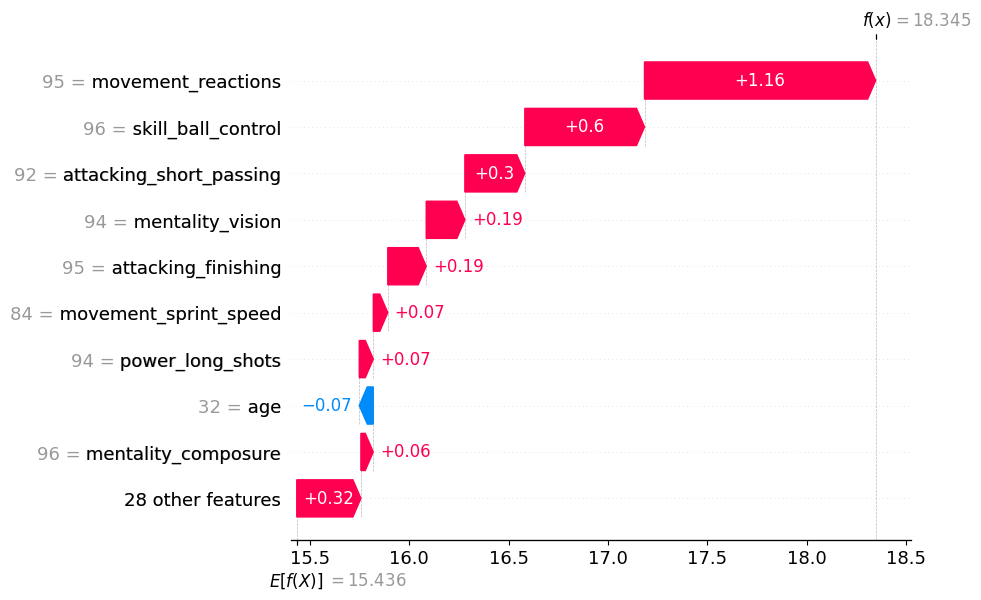

In [17]:
background = shap.utils.sample(X_train, 100, random_state=0)

idx = messi_position
x_messi = X_train.iloc[[idx]]

explainer = shap.TreeExplainer(model, data=background)
shap_values = explainer(x_messi)

shap.plots.waterfall(shap_values[0])


SHAP is a very good technique for analyzing variable importance over one particular instance. With the SHAP analysis, we see that the movement_reactions variable is the one most influencing Messi's prediction, in this case in a positive way. We see that this variable increases the final logits in 1.16, much more than any other one. Let's see if we get the same results with other methods.

In [130]:
feature_names = X_train.columns.tolist()

categorical_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

categorical_names = {
}

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    categorical_features=categorical_features if categorical_features else None,
    categorical_names=categorical_names if categorical_features else None,
    mode='regression',
    kernel_width=3
)

idx = messi_position
x = X_train.iloc[idx].values

exp = explainer.explain_instance(
    data_row=x,
    predict_fn=model.predict,
    num_features=min(10, len(feature_names))
)

exp.show_in_notebook(show_table=True)
print(f"Min value: {np.exp(12.36):.3f}, Max value: {np.exp(18.35):.3f}")

Min value: 233281.230, Max value: 93175931.444


LIME lets us understand which features have a positive or negative impact on a specific instance, as well as the magnitude of that influence, exactly what we need here with Messi. It approximates an interpretable model near the instance data of Messi, so we can understand the model's beahvior without explicitly lookinh at the model ouput, but rather an approximation. Here we see that age is a negative influence for Messi's value, as ii will decrease when Messi gets older. Movement reactions, interestingly enough, is the feature with the highest positive impact on his value.

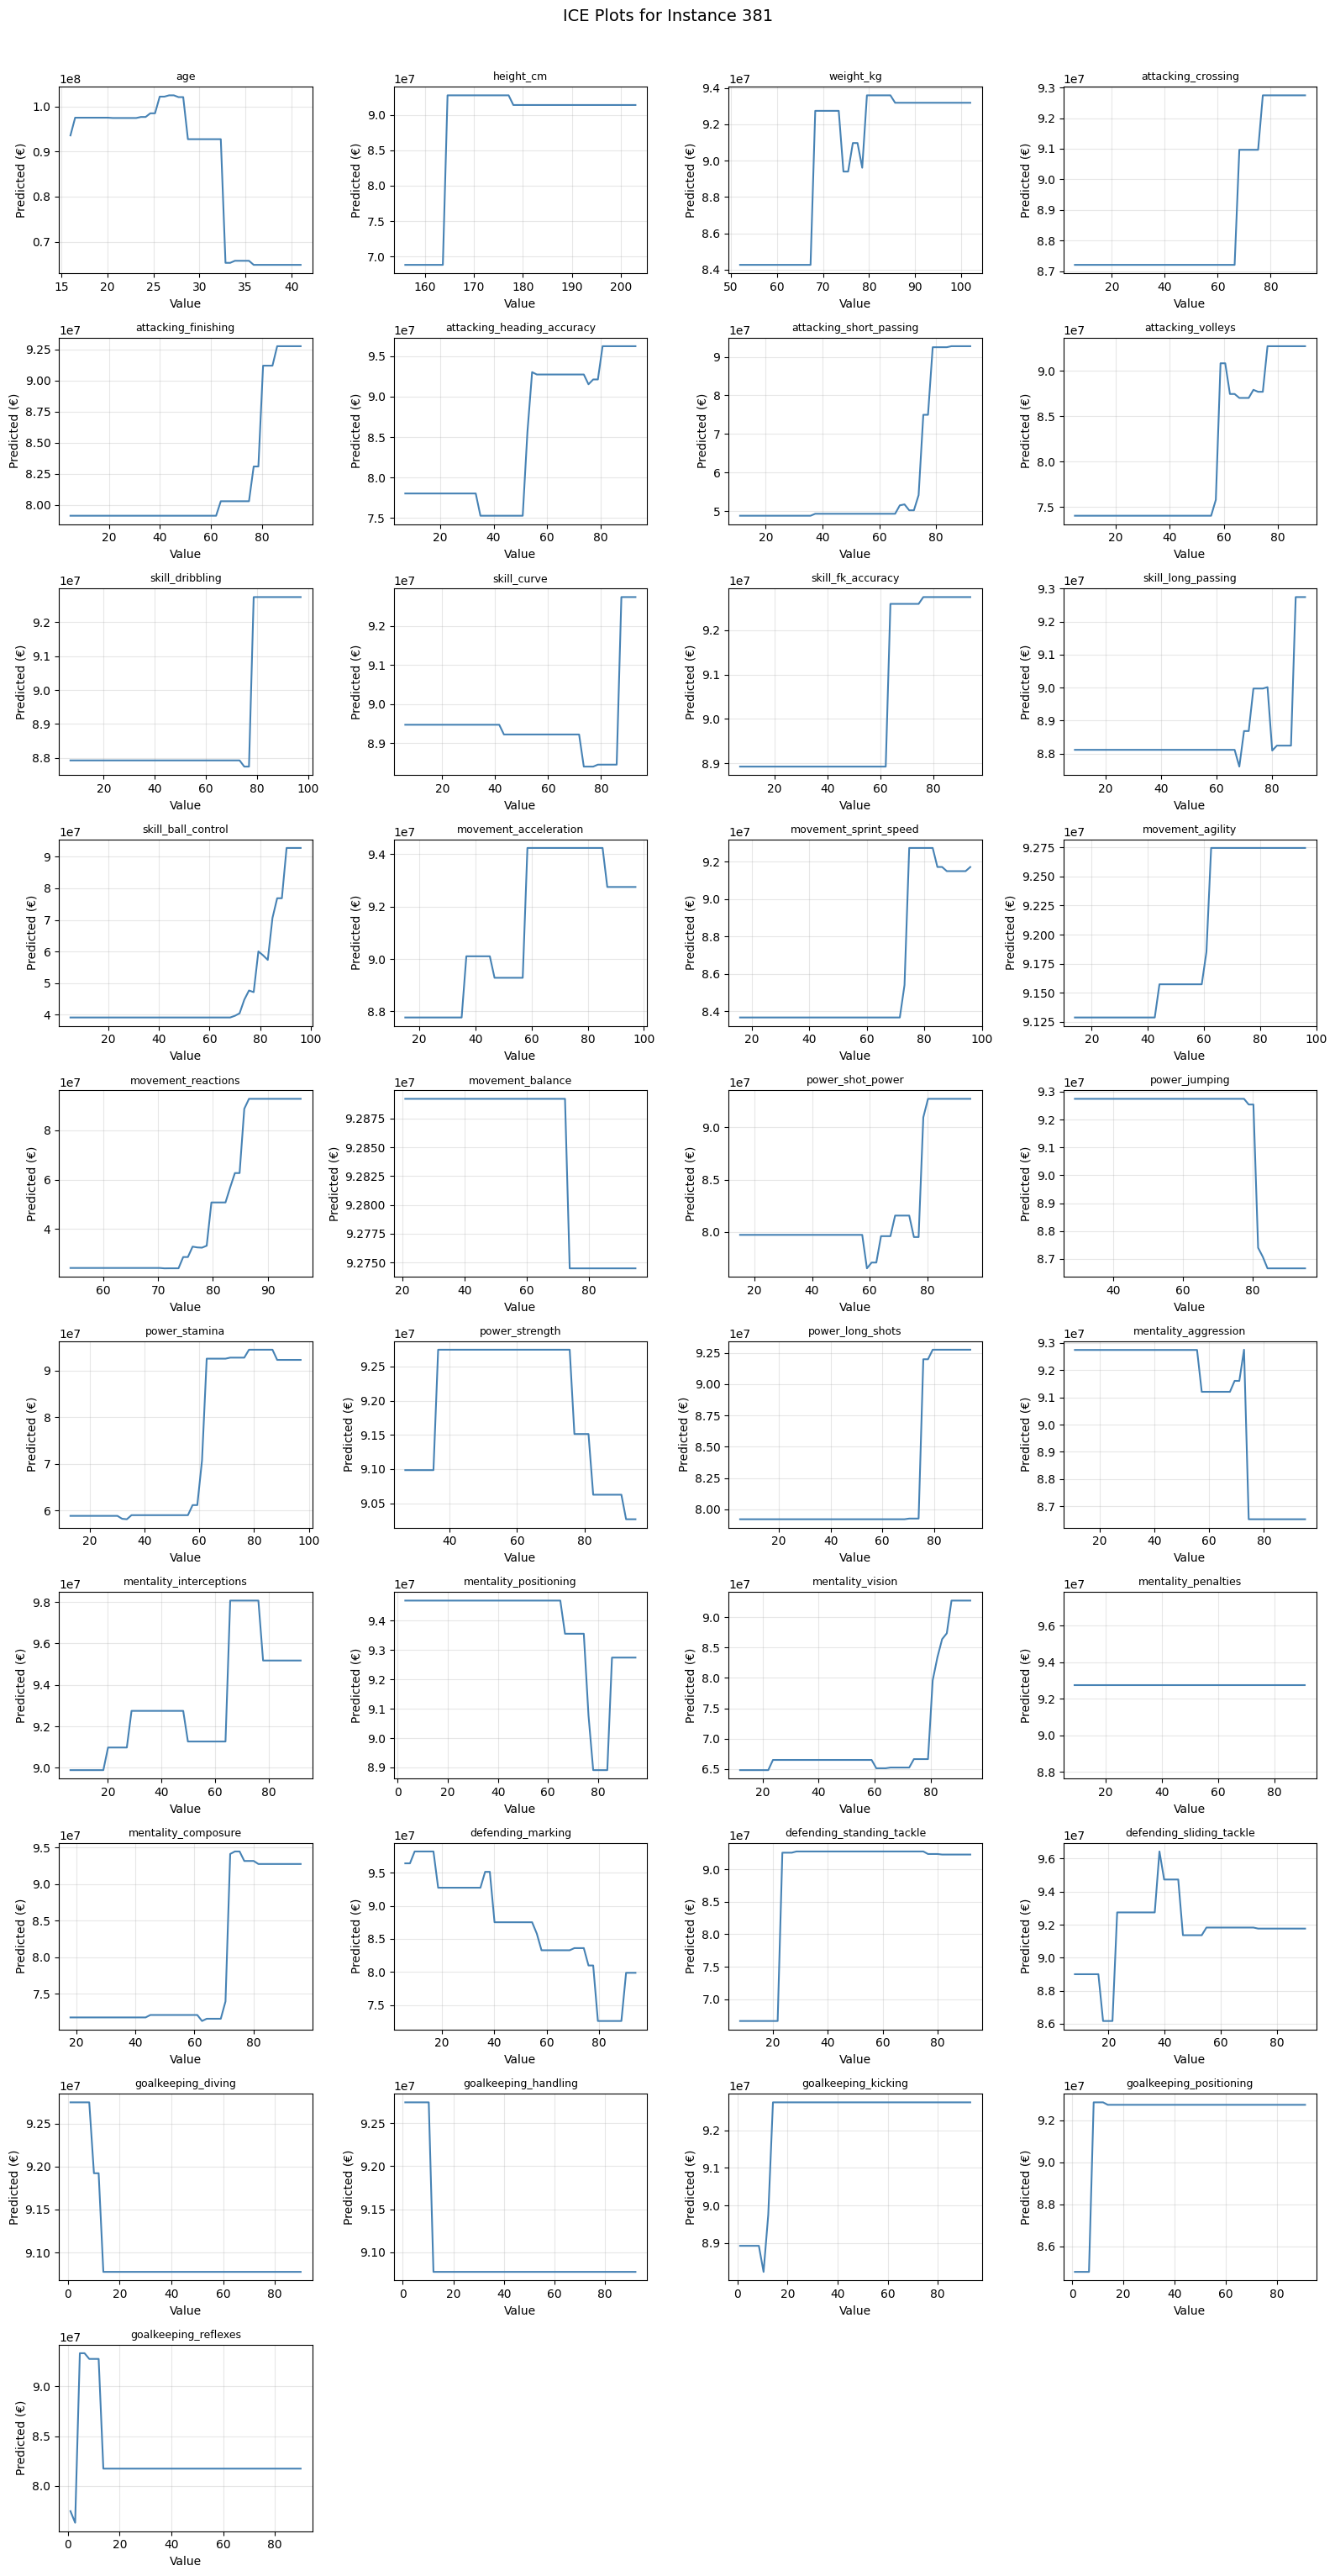

In [112]:
instance_index = messi_position
instance = X_train.iloc[[instance_index]]

num_points = 50

features = X_train.columns
n_features = len(features)

n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, feature_name in enumerate(features):
    ax = axes[i]
    original_value = instance[feature_name]
    feature_values = np.linspace(X_train[feature_name].min(), X_train[feature_name].max(), num_points)
    preds = []

    for v in feature_values:
        modified_instance = instance.copy()
        modified_instance[feature_name] = v
        preds.append(predict_function(model, modified_instance).item() - original_value)

    ax.plot(feature_values, preds, color='steelblue')
    ax.set_title(feature_name, fontsize=9)
    ax.set_xlabel("Value")
    ax.set_ylabel("Predicted (€)")
    ax.grid(True, alpha=0.3)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle(f"ICE Plots for Instance {instance_index}", fontsize=14, y=1.02)
plt.show()


>>> Your justification here
>>
To learn what is the most important feature for a certain instance, ICE plots are another useful tool, as they are designed just for that: comparing how a particular instance prediction changes when varying one feature and leaving the rest of them still. Comparing this variation over all featuers we can have a very good understansing of the model's behavior. Besides, using the c-ICE we remove the effect of slopes, so it's easier to identify the actual change per feature. Looking at the plots, we see that age and modement reactions are the two most important features, as they represent the biggest change in predicted price. This is the same result we obtained with LIME.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

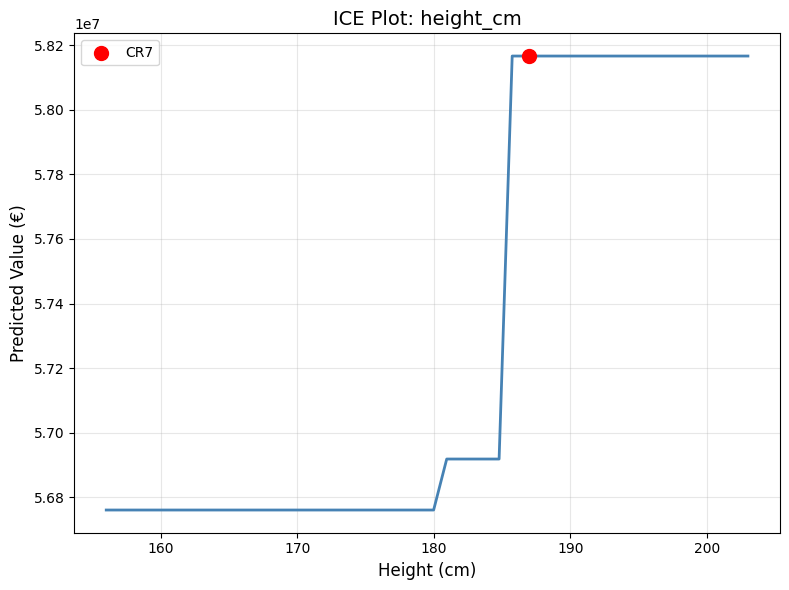

In [114]:
instance_index = cr7_position
instance = X_train.iloc[[instance_index]]

num_points = 50
features = ["height_cm"]

# Create single subplot
fig, ax = plt.subplots(figsize=(8, 6))

feature_name = features[0]

# Generate feature values
feature_values = np.linspace(
    X_train[feature_name].min(), 
    X_train[feature_name].max(), 
    num_points
)

# Calculate predictions
preds = []
for v in feature_values:
    modified_instance = instance.copy()
    modified_instance[feature_name] = v
    preds.append(predict_function(model, modified_instance).item())

# Plot
ax.plot(feature_values, preds, color='steelblue', linewidth=2)

# Mark the actual instance value
actual_value = instance[feature_name].values[0]
actual_pred = predict_function(model, instance).item()
ax.scatter([actual_value], [actual_pred], color='red', s=100, zorder=5, label='CR7')

ax.set_title(f"ICE Plot: {feature_name}", fontsize=14)
ax.set_xlabel("Height (cm)", fontsize=12)
ax.set_ylabel("Predicted Value (€)", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

>>> Your explanation here
>>
To analyze the effect of one variable over one instance, it's clear that ICE plot is the best solution. We see exactly that: how the value of CR7 changes when we move its height but keep the rest of the features still.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

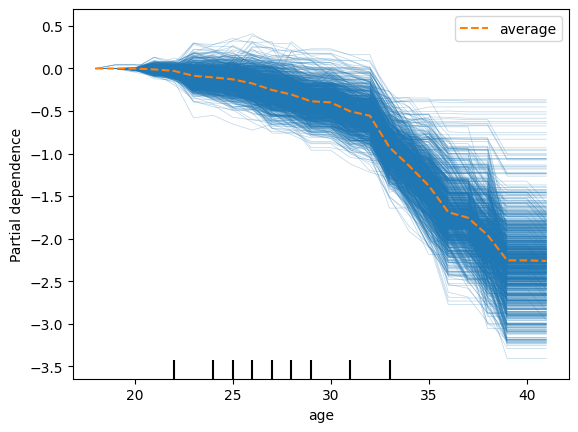

In [116]:
features = ["age"]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', centered=True)

Strikers: 24, Goalkeepers: 36, Others: 47


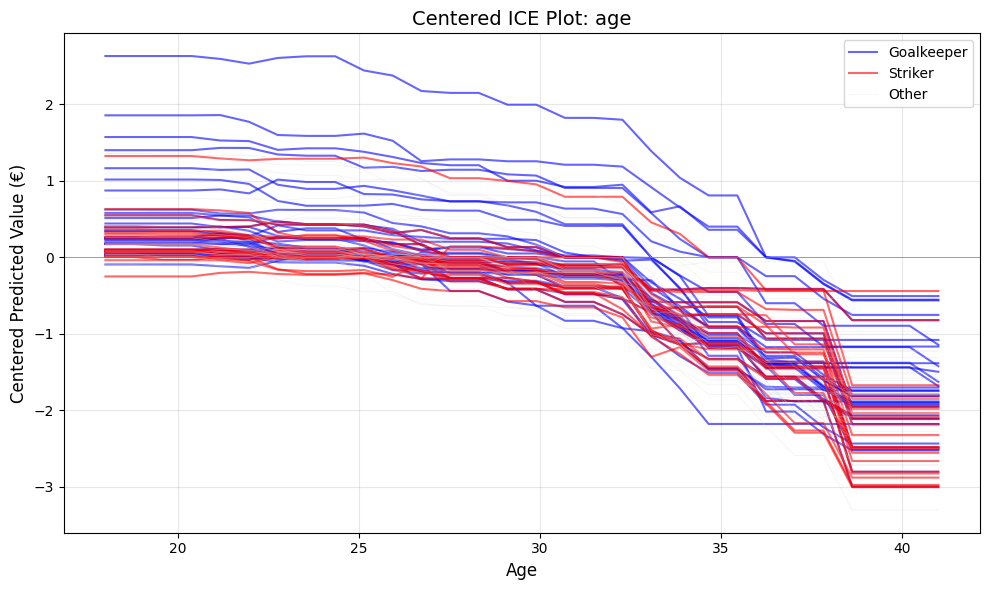

In [ ]:
striker_threshold = X_train['attacking_finishing'].quantile(0.80)
goalkeeper_threshold = X_train['goalkeeping_reflexes'].quantile(0.80)

n_samples = 100
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)

X_test_sample = X_test.iloc[sample_indices]

is_striker = X_test_sample['attacking_finishing'] >= striker_threshold
is_goalkeeper = X_test_sample['goalkeeping_reflexes'] >= goalkeeper_threshold

strikers = X_test_sample[is_striker]
goalkeepers = X_test_sample[is_goalkeeper]
others = X_test_sample[~is_striker & ~is_goalkeeper]

print(f"Strikers: {len(strikers)}, Goalkeepers: {len(goalkeepers)}, Others: {len(others)}")

feature_name = "age"
num_points = 30

fig, ax = plt.subplots(figsize=(10, 6))

feature_values = np.linspace(X_test[feature_name].min(), X_test[feature_name].max(), num_points)

def plot_group_ice(data, color, label, alpha=0.7, linewidth=1):
    centering_values = model.predict(data)
    
    for idx, (_, instance) in enumerate(data.iterrows()):
        preds = []
        for v in feature_values:
            modified = data.iloc[[idx]].copy()
            modified[feature_name] = v
            preds.append(model.predict(modified)[0])
        
        centered = np.array(preds) - centering_values[idx]
        ax.plot(feature_values, centered, color=color, alpha=alpha, linewidth=linewidth, 
                label=label if idx == 0 else None)

# Plot each group
plot_group_ice(goalkeepers, 'blue', 'Goalkeeper', alpha=0.6, linewidth=1.5)
plot_group_ice(strikers, 'red', 'Striker', alpha=0.6, linewidth=1.5)
plot_group_ice(others, 'lightgray', 'Other', alpha=0.3, linewidth=0.5)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel(feature_name.replace('_', ' ').title(), fontsize=12)
ax.set_ylabel('Centered Predicted Value (€)', fontsize=12)
ax.set_title(f'Centered ICE Plot: {feature_name}', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

>>> Your explanation here

A PDP in combination with another c-ICE perfectly describes the effect of the variable Age accross the dataset. We can see that as age increases, players' value starts to get down. It is expected thata this increase is more notable in strikers than in goalpkeepers, which is also what we confirm looking at the second plot: the most radical decreases are from strikers.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [129]:
feature_names = X_train.columns.tolist()

categorical_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

categorical_names = {
}

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    categorical_features=categorical_features if categorical_features else None,
    categorical_names=categorical_names if categorical_features else None,
    mode='regression',
    kernel_width=3
)

idx = bk_position
x = X_train.iloc[idx].values

exp = explainer.explain_instance(
    data_row=x,
    predict_fn=model.predict,
    num_features=min(10, len(feature_names))
)

exp.show_in_notebook(show_table=True)

# Recompute the log used by the model
print(f"Min value: {np.exp(12.):.3f}, Max value: {np.exp(18.31):.3f}")

Min value: 279288.339, Max value: 89522450.915


>>> Your explanation here
>>
LIME is a technique that approximates the model's behaviour around a particular instance, Hazard in this case, with an interpretable linear model. This way, we can know why the model chose a certain value for this instance in order to explain its behavior (for a loan can be really useful). It's local, so its insights are not generalizable. In the case of Hazard, we see that the variables that had the highest positive impact on his value are sorted under the positive tag, being the two first ones particularly important in pushing his value upward.